In [1]:
%load_ext autoreload
%autoreload 2
from ff_energy.ffe.slurm import SlurmJobHandler
from pathlib import Path
import pandas as pd
import jax.numpy as jnp
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.potential import (
    LJ,
    DE,
)
from ff_energy.ffe.ff import FF
from ff_energy.ffe.constants import FFEPATH, PDB_PATH
from ff_energy.plotting.ffe_plots import plot_energy_MSE, plot_ff_fit
from ff_energy.plotting.plotting import set_style
from ff_energy.plotting.fit_results import residuals_plot, residuals_from_keys
from ff_energy.logs.logging import hide_logs
from ff_energy.ffe.potential import LJ, LJ_bound, DE

hide_logs()
import scienceplots
set_style(no_latex=True)

from ff_energy.ffe.ff_fit import (
    load_ff,
    fit_func,
    fit_repeat,
)

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, PKL_PATH
from ff_energy.utils.json_utils import load_json
from ff_energy.ffe.structure import atom_key_pairs

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, \
    PKL_PATH, get_structures

0 ('C', 'C')
1 ('C', 'CG331')
2 ('C', 'CL')
3 ('C', 'CLA')
4 ('C', 'H')
5 ('C', 'HGA3')
6 ('C', 'HGP1')
7 ('C', 'HT')
8 ('C', 'OG311')
9 ('C', 'OT')
10 ('C', 'POT')
11 ('CG331', 'CG331')
12 ('CG331', 'CL')
13 ('CG331', 'CLA')
14 ('CG331', 'H')
15 ('CG331', 'HGA3')
16 ('CG331', 'HGP1')
17 ('CG331', 'HT')
18 ('CG331', 'OG311')
19 ('CG331', 'OT')
20 ('CG331', 'POT')
21 ('CL', 'CL')
22 ('CL', 'CLA')
23 ('CL', 'H')
24 ('CL', 'HGA3')
25 ('CL', 'HGP1')
26 ('CL', 'HT')
27 ('CL', 'OG311')
28 ('CL', 'OT')
29 ('CL', 'POT')
30 ('CLA', 'CLA')
31 ('CLA', 'H')
32 ('CLA', 'HGA3')
33 ('CLA', 'HGP1')
34 ('CLA', 'HT')
35 ('CLA', 'OG311')
36 ('CLA', 'OT')
37 ('CLA', 'POT')
38 ('H', 'H')
39 ('H', 'HGA3')
40 ('H', 'HGP1')
41 ('H', 'HT')
42 ('H', 'OG311')
43 ('H', 'OT')
44 ('H', 'POT')
45 ('HGA3', 'HGA3')
46 ('HGA3', 'HGP1')
47 ('HGA3', 'HT')
48 ('HGA3', 'OG311')
49 ('HGA3', 'OT')
50 ('HGA3', 'POT')
51 ('HGP1', 'HGP1')
52 ('HGP1', 'HT')
53 ('HGP1', 'OG311')
54 ('HGP1', 'OT')
55 ('HGP1', 'POT')
56 ('HT', 'HT'

<Figure size 100x100 with 0 Axes>

#  Gathering Data

In [2]:
ci_outfiles = list(Path("/home/boittier/homeb/water_dimer/pbe0dz").glob("*/coloumb/*py.out"))

In [3]:
def stem2key(s):
    return str(s).split("_")[0]+".xyz"

ci_res = {stem2key(ci_outfiles[i].stem): float(open(ci_outfiles[i]
          ).readlines()[-1].split()[0]) for i,v in enumerate(ci_outfiles)}
# ci_res

In [4]:
water_pairs_mdcm = next(read_from_pickle(PKL_PATH / "water_dimer_pbe0dz_mdcm.pkl" ))

water_pairs_mdcm.data.index = water_pairs_mdcm.data["KEY"]

water_pairs_mdcm.data.head()

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol
KEY,,,,,,,,,
24-3.xyz,15.61750,-0.03748,-0.00138,24-3.xyz,-152.714146,2,-152.714219,-0.046228,-95828.630797
16-1.xyz,15.53494,-0.06371,-0.00065,16-1.xyz,-152.714178,2,-152.714294,-0.072558,-95828.677402
23-2.xyz,15.50320,-0.09132,-0.00268,23-2.xyz,-152.714183,2,-152.714358,-0.109292,-95828.717556
15-2.xyz,15.60681,-0.11017,-0.00259,15-2.xyz,-152.714150,2,-152.714358,-0.130000,-95828.717537
11-5.xyz,15.82777,-0.88561,-0.11543,11-5.xyz,-152.714134,2,-152.716202,-1.298059,-95829.875086


In [5]:
water_pairs_pc = next(read_from_pickle(PKL_PATH / "water_dimer_pbe0dz_pc.pkl" ))
water_pairs_pc.data.index = water_pairs_pc.data["KEY"]

In [6]:
water_pairs_pc.data.head()

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol
KEY,,,,,,,,,
24-3.xyz,15.61286,-0.02990,-0.00138,24-3.xyz,-152.714146,2,-152.714219,-0.046228,-95828.630797
16-1.xyz,15.53172,-0.06388,-0.00065,16-1.xyz,-152.714178,2,-152.714294,-0.072558,-95828.677402
23-2.xyz,15.49687,-0.08467,-0.00268,23-2.xyz,-152.714183,2,-152.714358,-0.109292,-95828.717556
15-2.xyz,15.60052,-0.10594,-0.00259,15-2.xyz,-152.714150,2,-152.714358,-0.130000,-95828.717537
11-5.xyz,15.75028,-0.68214,-0.11543,11-5.xyz,-152.714134,2,-152.716202,-1.298059,-95829.875086


In [7]:
structure = "dimer3d"
structs, _ = get_structures(structure,
                            pdbpath=PDB_PATH / structure)


Structure/PDB already already exists, loading from pickle
Structures/PDBs loaded 104 104


In [8]:
order = [x.stem for x in _]
order[:4]

# order = [_ for _ in order if _.__contains__("-1.")]


['7-3.xyz', '3-1.xyz', '8-2.xyz', '3-3.xyz']

In [9]:
OOdists = [float(s.distances[-3][0]) for s in structs]
# OOdists

In [10]:
CI_ordered = [ci_res[_] for _ in order]

In [11]:
#  reorder the dataframe
water_pairs_pc.data = water_pairs_pc.data.loc[order]
#  add oo column
water_pairs_pc.data["OO"] = OOdists
water_pairs_pc.data["CI"] = CI_ordered
#  reorder the dataframe
water_pairs_mdcm.data = water_pairs_mdcm.data.loc[order]
#  add oo column
water_pairs_mdcm.data["OO"] = OOdists
water_pairs_mdcm.data["CI"] = CI_ordered

In [73]:
[_ for _ in order if _.__contains__("-1.")]

['3-1.xyz',
 '12-1.xyz',
 '14-1.xyz',
 '5-1.xyz',
 '16-1.xyz',
 '13-1.xyz',
 '18-1.xyz',
 '6-1.xyz',
 '23-1.xyz',
 '11-1.xyz',
 '24-1.xyz',
 '2-1.xyz',
 '15-1.xyz',
 '10-1.xyz',
 '9-1.xyz',
 '7-1.xyz',
 '4-1.xyz',
 '21-1.xyz',
 '22-1.xyz',
 '8-1.xyz',
 '1-1.xyz',
 '20-1.xyz',
 '19-1.xyz',
 '17-1.xyz']

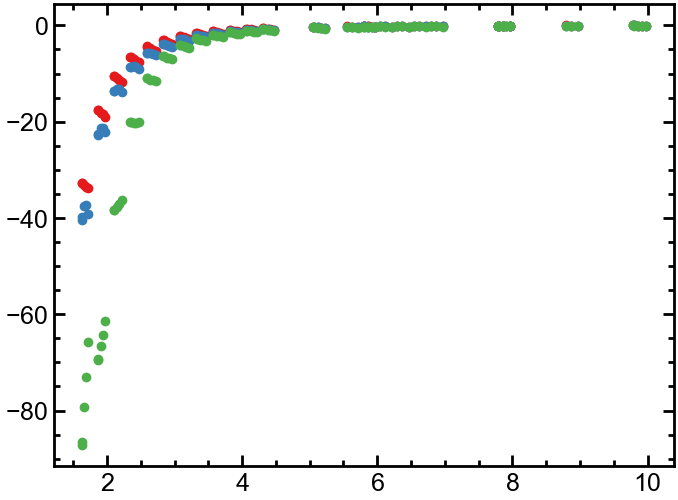

In [12]:
plt.scatter(
    water_pairs_pc.data["OO"], 
    water_pairs_pc.data["ELEC"]
)
plt.scatter(
    water_pairs_mdcm.data["OO"], 
    water_pairs_mdcm.data["ELEC"]
)
plt.scatter(
    water_pairs_mdcm.data["OO"], 
    water_pairs_mdcm.data["CI"]
)

In [13]:
water_pairs_mdcm.data.head()

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,OO,CI
KEY,,,,,,,,,,,
7-3.xyz,16.19927,-2.92703,-0.05571,7-3.xyz,-152.714187,2,-152.720285,-3.826105,-95832.436772,3.136005,-4.287218
3-1.xyz,103.43002,-13.76665,55.36028,3-1.xyz,-152.714178,2,-152.692457,13.629999,-95814.974845,2.220000,-36.208867
8-2.xyz,16.09964,-2.30396,-0.19049,8-2.xyz,-152.714159,2,-152.719355,-3.261026,-95831.853653,3.422211,-3.093374
3-3.xyz,136.68473,-13.15799,73.08732,3-3.xyz,-152.714183,2,-152.684671,18.518875,-95810.089389,2.151257,-37.758212
9-3.xyz,15.94861,-1.65216,-0.17710,9-3.xyz,-152.714183,2,-152.718003,-2.397030,-95831.005294,3.630790,-2.123595


In [14]:
RCUT = 2.1
water_pairs_pc.data = water_pairs_pc.data[water_pairs_pc.data["OO"] > RCUT]
water_pairs_mdcm.data = water_pairs_mdcm.data[water_pairs_mdcm.data["OO"] > RCUT]

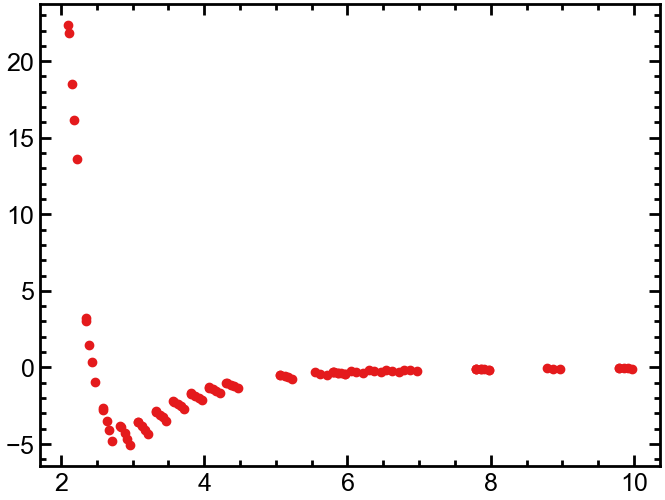

In [15]:
plt.scatter(
    water_pairs_mdcm.data["OO"], 
    water_pairs_mdcm.data["intE"]
)

#  Force Feild Object

In [16]:
dists = {str(s.name)[:-4]: s.distances for s in structs}
struct_data = structs[0]
sig_bound = (0.0025, 5.5)
ep_bound = (0.001, 1.0)
alpha_bound = (1, 8)
beta_bound = (2, 14)

In [17]:
def ff_train(fit, elec, target, data):
    if fit == "lj":
        FUNC = LJ
        BOUNDS = []
        for i in range(len(set(struct_data.chm_typ))):
            BOUNDS.append(sig_bound)
        for i in range(len(set(struct_data.chm_typ))):
            BOUNDS.append(ep_bound)
    elif fit == "de":
        FUNC = DE
        BOUNDS = []
        for i in range(len(set(struct_data.chm_typ))):
            BOUNDS.append(sig_bound)
        for i in range(len(set(struct_data.chm_typ))):
            BOUNDS.append(ep_bound)
        BOUNDS.append(alpha_bound)
        BOUNDS.append(beta_bound)
    else:
        raise ValueError("Invalid fit type")

    ljpcff = FF(
        data,
        dists,
        FUNC,
        BOUNDS,
        struct_data,
        elec=elec,
        intE=target,
    )
    #  set the targets
    ljpcff.num_segments = len(ljpcff.data)
    ljpcff.set_targets()
    
    if fit == "de":
        loss = "jax_de"
    else:
        loss = "jax"

    ljpcff_fit = fit_repeat(ljpcff,
                     200,
                     "dimer3d_fit",
                     loss=loss,
                           quiet=True)
    return ljpcff_fit


#  PC

In [18]:
fit = "lj"
elec = "ELEC"
target = "intE"
data = water_pairs_pc.data
ljpcff_fit = ff_train(fit, elec, target, data)

2023-10-05 12:12:09 | INFO | xla_bridge:backends:450 - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-10-05 12:12:09 | INFO | xla_bridge:backends:450 - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-10-05 12:12:09 | INFO | xla_bridge:backends:450 - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-10-05 12:12:09 | INFO | xla_bridge:backends:450 - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-10-05 12:12:09 | WARNING | xla_bridge:backends:458 - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
KEY
10-1.xyz   -2.125892
10-2.xyz   -1.967529
10-3.xyz   -1.848944
10-4.xyz   -1.710780
10-5.xyz   -1.696969
              ...   
9-1.xyz    -2.725145
9-2.xyz    -2.537622
9-3.xyz    -2.397030
9-4.xyz    -2.238090
9-5.xyz    -2.219390
Name: intE, Length: 94, dtype: float64
count    94.000000
mean     -0.219343
std       4.794958
min      -5.094565
25%      -2.233415
50%      -0.463646
75%      -0.142239
max      22.334219
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [2.5290373697042345, 3.3776111466602554, 0.46000812949264863, 0.4840989856072844]
sig [5.058074739408469, 5.9066485163644895, 6.755222293320511]
ep [0.46000812949264863, 0.4718998504539873, 0.4840989856072844]
epsilons {'HT': 0.46000812949264863, 'OT':

In [19]:
pd.DataFrame(ljpcff_fit.opt_results).sort_values("fun").head()

,fun,nit,nfev,status,success,message,x,final_simplex
97,0.910608,1047,1746,0,True,Optimization terminated successfully.,"[0.3216835352184335, 2.4242026682485904, 0.001...","([[0.3216835352184335, 2.4242026682485904, 0.0..."
0,0.910608,957,1603,0,True,Optimization terminated successfully.,"[0.3217813240642303, 2.424193027294643, 0.001,...","([[0.3217813240642303, 2.424193027294643, 0.00..."
140,0.910609,1250,2066,0,True,Optimization terminated successfully.,"[0.32212072711284534, 2.4240312366300545, 0.00...","([[0.32212072711284534, 2.4240312366300545, 0...."
113,0.910633,775,1310,0,True,Optimization terminated successfully.,"[0.32021028692420905, 2.42481648398738, 0.0010...","([[0.32021028692420905, 2.42481648398738, 0.00..."
80,0.910639,965,1626,0,True,Optimization terminated successfully.,"[0.3195809682398969, 2.424415698549999, 0.0010...","([[0.3195809682398969, 2.424415698549999, 0.00..."


Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


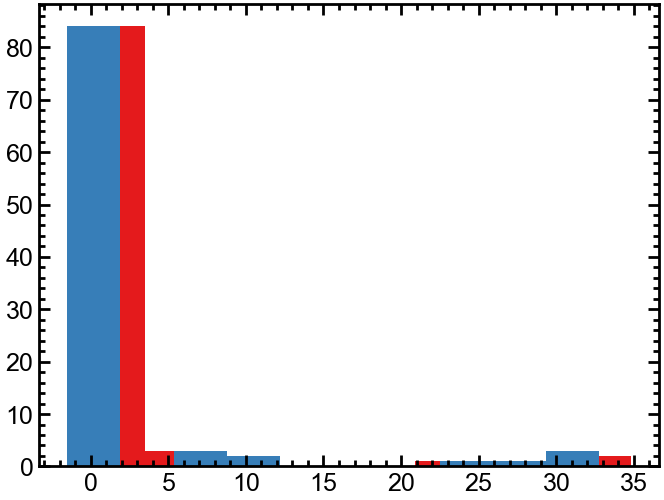

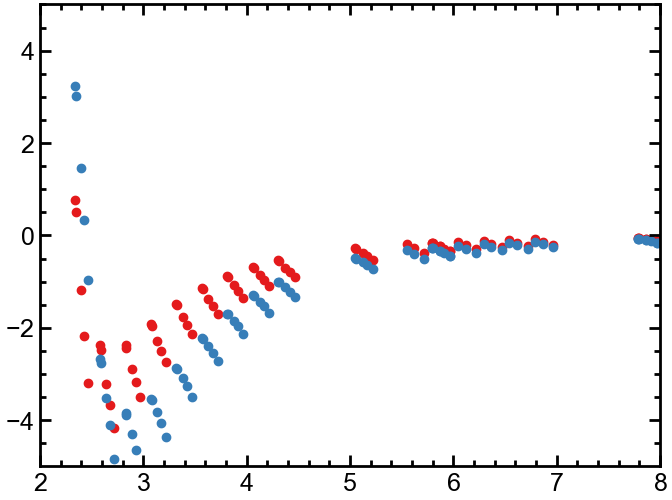

(-5.0, 5.0)

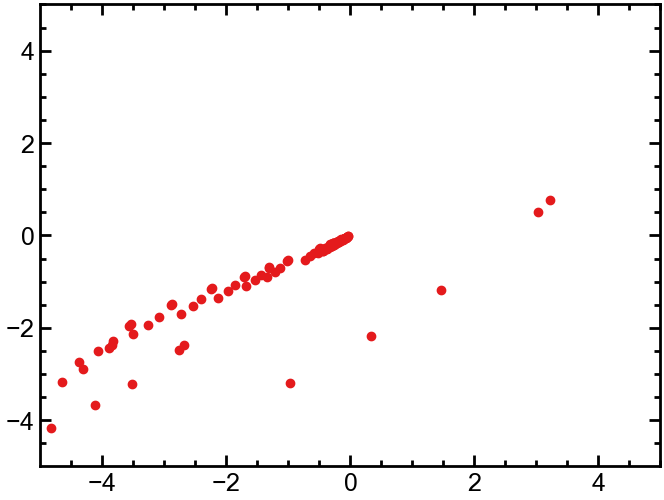

In [20]:
ffeval = ljpcff_fit.eval_best_parm()
plt.hist(ffeval)
plt.hist(ljpcff_fit.targets)
plt.show()

ljpcff_fit.data["eval"] = ffeval

plt.scatter(
    ljpcff_fit.data["OO"], 
    ljpcff_fit.data["eval"] + ljpcff_fit.data["ELEC"]
)

plt.scatter(
    ljpcff_fit.data["OO"], 
    ljpcff_fit.data["intE"]
)

plt.xlim(2,8)
plt.ylim(-5,5)

plt.show()

plt.scatter(
    ljpcff_fit.data["intE"],
    ljpcff_fit.data["eval"] + ljpcff_fit.data["ELEC"],
           )

LJPC = ljpcff_fit.data["eval"] + ljpcff_fit.data["ELEC"]

plt.xlim(-5,5)
plt.ylim(-5,5)

In [21]:
fit = "de"
elec = "ELEC"
target = "intE"
data = water_pairs_pc.data
depcff_fit = ff_train(fit, elec, target, data)

Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 6 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (1, 8), (6, 20)]
Interaction energy:
KEY
10-1.xyz   -2.125892
10-2.xyz   -1.967529
10-3.xyz   -1.848944
10-4.xyz   -1.710780
10-5.xyz   -1.696969
              ...   
9-1.xyz    -2.725145
9-2.xyz    -2.537622
9-3.xyz    -2.397030
9-4.xyz    -2.238090
9-5.xyz    -2.219390
Name: intE, Length: 94, dtype: float64
count    94.000000
mean     -0.219343
std       4.794958
min      -5.094565
25%      -2.233415
50%      -0.463646
75%      -0.142239
max      22.334219
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [2.454442412780001, 0.469486704461209, 0.1021130094397381, 0.916512234535174, 4.942543514694327, 5.844121047063158]
sig [4.908884825560002, 2.92392911724121, 0.938973408922418]
ep [0.1021130094397381, 0.3059212683955231, 0.916512234535

In [22]:
res = pd.DataFrame(depcff_fit.opt_results).sort_values("fun")
parm = res["x"].iloc[0]
res.head()

,fun,nit,nfev,status,success,message,x,final_simplex
62,0.355974,1689,2659,0,True,Optimization terminated successfully.,"[0.36566976905617876, 2.0242258827836075, 0.09...","([[0.36566976905617876, 2.0242258827836075, 0...."
75,0.355974,1381,2114,0,True,Optimization terminated successfully.,"[0.36560115095904655, 2.0241860288238995, 0.09...","([[0.36560115095904655, 2.0241860288238995, 0...."
131,0.355975,664,1083,0,True,Optimization terminated successfully.,"[0.36604770899812367, 2.024245433809101, 0.099...","([[0.36604770899812367, 2.024245433809101, 0.0..."
0,0.355978,2241,3448,0,True,Optimization terminated successfully.,"[0.3652811356485863, 2.0242508172345968, 0.099...","([[0.3652811356485863, 2.0242508172345968, 0.0..."
159,0.355978,1040,1642,0,True,Optimization terminated successfully.,"[0.3652594519247651, 2.0242091308197403, 0.099...","([[0.3652594519247651, 2.0242091308197403, 0.0..."


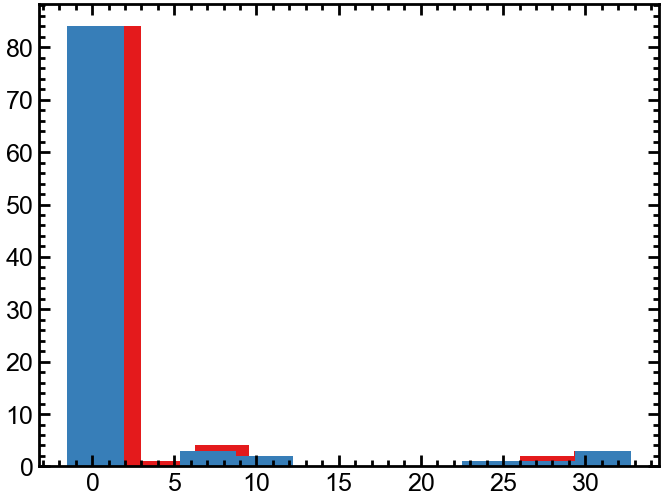

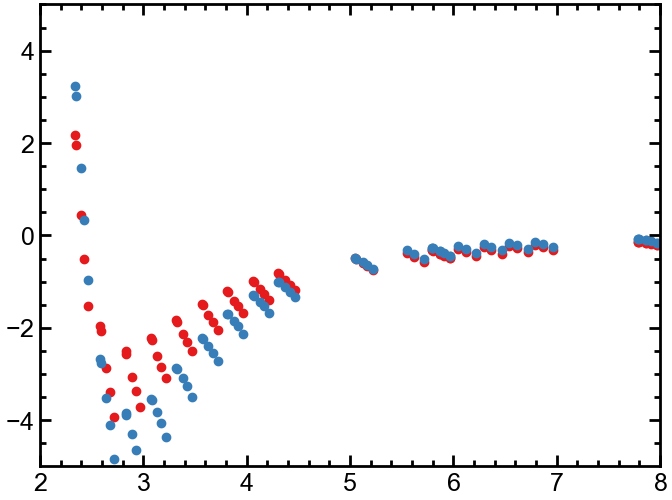

(-5.0, 5.0)

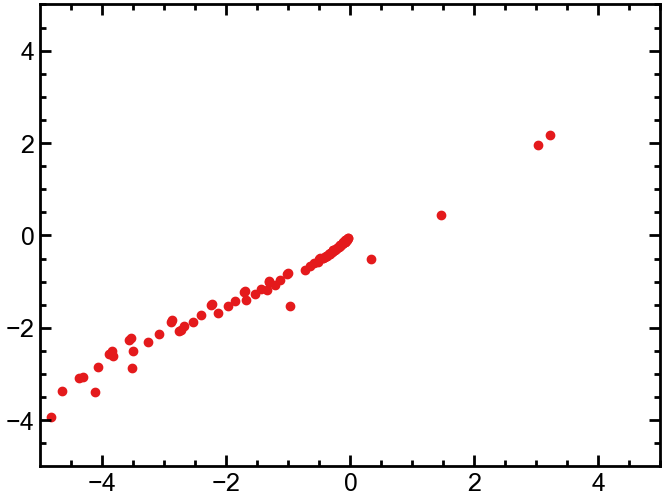

In [23]:
ffeval = depcff_fit.eval_jax_de(parm)
plt.hist(ffeval)
plt.hist(ljpcff_fit.targets)
plt.show()

depcff_fit.data["eval"] = ffeval

plt.scatter(
    depcff_fit.data["OO"], 
    depcff_fit.data["eval"] + depcff_fit.data["ELEC"]
)

plt.scatter(
    depcff_fit.data["OO"], 
    depcff_fit.data["intE"]
)

plt.xlim(2,8)
plt.ylim(-5,5)

plt.show()

plt.scatter(
    depcff_fit.data["intE"],
    depcff_fit.data["eval"] + depcff_fit.data["ELEC"],
           )
DEPC = depcff_fit.data["eval"] + depcff_fit.data["ELEC"]
plt.xlim(-5,5)
plt.ylim(-5,5)

#  CI

In [24]:
fit = "lj"
elec = "CI"
target = "intE"
data = water_pairs_pc.data
ljpcff_fit = ff_train(fit, elec, target, data)

Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
KEY
10-1.xyz   -2.125892
10-2.xyz   -1.967529
10-3.xyz   -1.848944
10-4.xyz   -1.710780
10-5.xyz   -1.696969
              ...   
9-1.xyz    -2.725145
9-2.xyz    -2.537622
9-3.xyz    -2.397030
9-4.xyz    -2.238090
9-5.xyz    -2.219390
Name: intE, Length: 94, dtype: float64
count    94.000000
mean     -0.219343
std       4.794958
min      -5.094565
25%      -2.233415
50%      -0.463646
75%      -0.142239
max      22.334219
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [2.73252786302078, 2.3141279547647278, 0.68249085680344, 0.9397287799791527]
sig [5.46505572604156, 5.046655817785508, 4.6282559095294555]
ep [0.68249085680344, 0.8008472389980646, 0.9397287799791527]
epsilons {'HT': 0.68249085680344, 'OT': 0.939728779

In [25]:
pd.DataFrame(ljpcff_fit.opt_results).sort_values("fun").head()

,fun,nit,nfev,status,success,message,x,final_simplex
82,4.534995,512,902,0,True,Optimization terminated successfully.,"[2.2205401811902705, 0.10000000000000009, 0.00...","([[2.2205401811902705, 0.10000000000000009, 0...."
31,4.534995,478,819,0,True,Optimization terminated successfully.,"[2.2211627530350784, 0.10000000000002332, 0.00...","([[2.2211627530350784, 0.10000000000002332, 0...."
90,4.534996,508,913,0,True,Optimization terminated successfully.,"[2.221389666153075, 0.10000000000000009, 0.001...","([[2.221389666153075, 0.10000000000000009, 0.0..."
61,4.534996,449,802,0,True,Optimization terminated successfully.,"[2.2218041456763986, 0.10000000000000002, 0.00...","([[2.2218041456763986, 0.10000000000000002, 0...."
85,4.534996,464,835,0,True,Optimization terminated successfully.,"[2.2214792222373765, 0.10000000000000003, 0.00...","([[2.2214792222373765, 0.10000000000000003, 0...."


Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


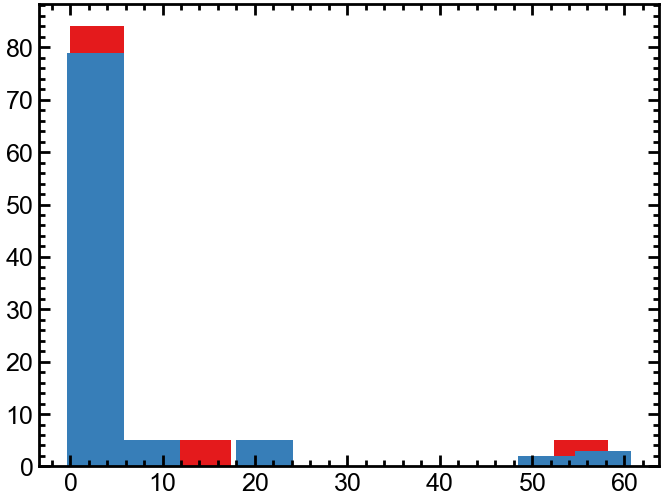

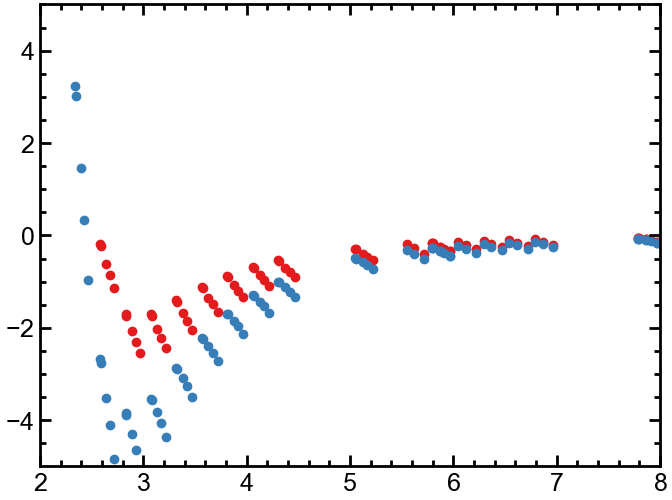

(-5.0, 5.0)

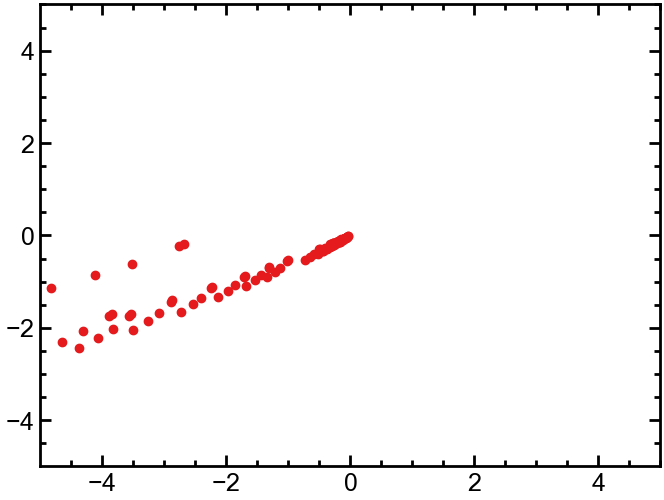

In [26]:
ffeval = ljpcff_fit.eval_best_parm()
plt.hist(ffeval)
plt.hist(ljpcff_fit.targets)
plt.show()

ljpcff_fit.data["eval"] = ffeval

plt.scatter(
    ljpcff_fit.data["OO"], 
    ljpcff_fit.data["eval"] + ljpcff_fit.data["ELEC"]
)

plt.scatter(
    ljpcff_fit.data["OO"], 
    ljpcff_fit.data["intE"]
)

plt.xlim(2,8)
plt.ylim(-5,5)

plt.show()

plt.scatter(
    ljpcff_fit.data["intE"],
    ljpcff_fit.data["eval"] + ljpcff_fit.data["ELEC"],
           )

LJCI = ljpcff_fit.data["eval"] + ljpcff_fit.data["ELEC"]

plt.xlim(-5,5)
plt.ylim(-5,5)

In [27]:
fit = "de"
elec = "CI"
target = "intE"
data = water_pairs_pc.data
depcff_fit = ff_train(fit, elec, target, data)

Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 6 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (1, 8), (6, 20)]
Interaction energy:
KEY
10-1.xyz   -2.125892
10-2.xyz   -1.967529
10-3.xyz   -1.848944
10-4.xyz   -1.710780
10-5.xyz   -1.696969
              ...   
9-1.xyz    -2.725145
9-2.xyz    -2.537622
9-3.xyz    -2.397030
9-4.xyz    -2.238090
9-5.xyz    -2.219390
Name: intE, Length: 94, dtype: float64
count    94.000000
mean     -0.219343
std       4.794958
min      -5.094565
25%      -2.233415
50%      -0.463646
75%      -0.142239
max      22.334219
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [0.8735427555039924, 2.4909293936896995, 0.10799775117838702, 0.46038772485572904, 4.392468296643166, 6.481565992857039]
sig [1.7470855110079848, 3.3644721491936918, 4.981858787379399]
ep [0.10799775117838702, 0.22298170094102504, 0.46

In [28]:
res = pd.DataFrame(depcff_fit.opt_results).sort_values("fun")
parm = res["x"].iloc[0]
res.head()

,fun,nit,nfev,status,success,message,x,final_simplex
148,0.034010,1646,2577,0,True,Optimization terminated successfully.,"[1.382762112298253, 1.85545903918812, 0.001050...","([[1.382762112298253, 1.85545903918812, 0.0010..."
156,0.034992,1128,1789,0,True,Optimization terminated successfully.,"[1.3894914210334424, 1.858904649333759, 0.0010...","([[1.3894914210334424, 1.858904649333759, 0.00..."
198,0.035268,1718,2691,0,True,Optimization terminated successfully.,"[1.390106985135504, 1.8600219316773476, 0.0010...","([[1.390106985135504, 1.8600219316773476, 0.00..."
140,0.036563,429,761,0,True,Optimization terminated successfully.,"[1.1710165024272265, 1.8915157204835364, 0.002...","([[1.1710165024272265, 1.8915157204835364, 0.0..."
27,0.037143,1352,2136,0,True,Optimization terminated successfully.,"[1.1612978580826998, 1.8921736550290689, 0.002...","([[1.1612978580826998, 1.8921736550290689, 0.0..."


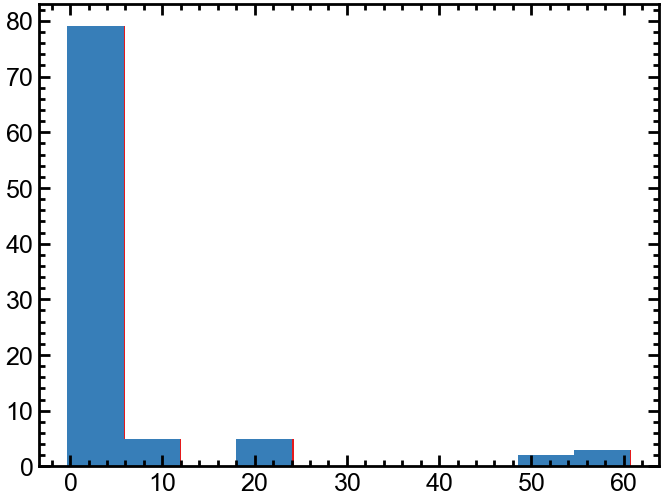

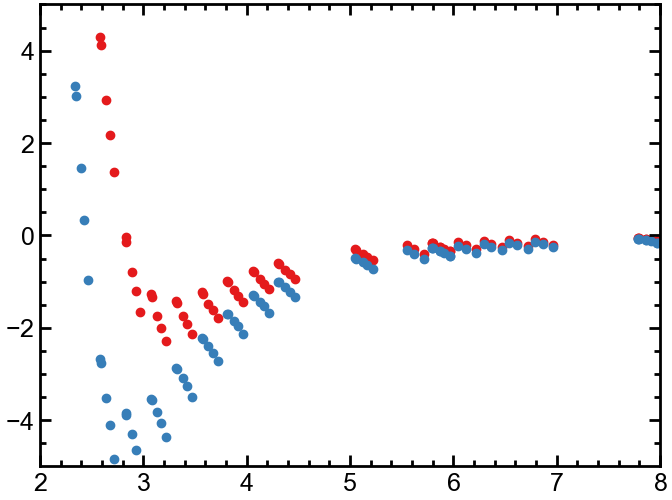

(-5.0, 5.0)

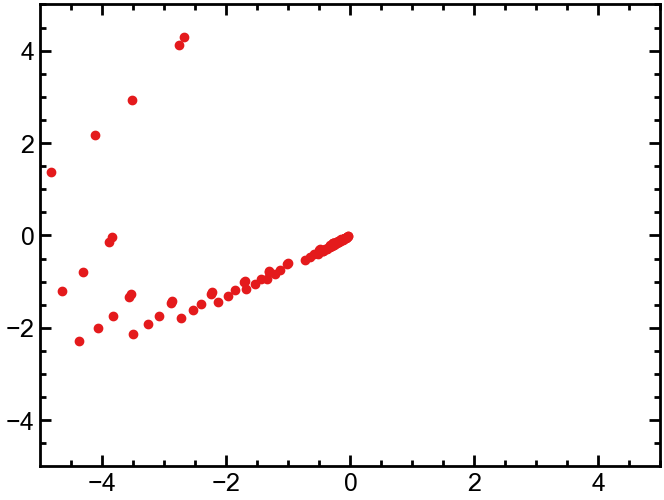

In [29]:
ffeval = depcff_fit.eval_jax_de(parm)
plt.hist(ffeval)
plt.hist(ljpcff_fit.targets)
plt.show()

depcff_fit.data["eval"] = ffeval

plt.scatter(
    depcff_fit.data["OO"], 
    depcff_fit.data["eval"] + depcff_fit.data["ELEC"]
)

plt.scatter(
    depcff_fit.data["OO"], 
    depcff_fit.data["intE"]
)

plt.xlim(2,8)
plt.ylim(-5,5)

plt.show()

plt.scatter(
    depcff_fit.data["intE"],
    depcff_fit.data["eval"] + depcff_fit.data["ELEC"],
           )

DECI = depcff_fit.data["eval"] + depcff_fit.data["ELEC"]

plt.xlim(-5,5)
plt.ylim(-5,5)

In [30]:
fit = "lj"
elec = "ELEC"
target = "intE"
data = water_pairs_mdcm.data
ljpcff_fit = ff_train(fit, elec, target, data)

Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
KEY
10-1.xyz   -2.125892
10-2.xyz   -1.967529
10-3.xyz   -1.848944
10-4.xyz   -1.710780
10-5.xyz   -1.696969
              ...   
9-1.xyz    -2.725145
9-2.xyz    -2.537622
9-3.xyz    -2.397030
9-4.xyz    -2.238090
9-5.xyz    -2.219390
Name: intE, Length: 94, dtype: float64
count    94.000000
mean     -0.219343
std       4.794958
min      -5.094565
25%      -2.233415
50%      -0.463646
75%      -0.142239
max      22.334219
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [2.7332409335139554, 5.44914874879173, 0.07957414344917933, 0.2987244564800674]
sig [5.466481867027911, 8.182389682305686, 10.89829749758346]
ep [0.07957414344917933, 0.1541776337596443, 0.2987244564800674]
epsilons {'HT': 0.07957414344917933, 'OT': 0.

In [31]:
pd.DataFrame(ljpcff_fit.opt_results).sort_values("fun").head()

,fun,nit,nfev,status,success,message,x,final_simplex
121,0.945048,760,1298,0,True,Optimization terminated successfully.,"[0.22267110392558015, 2.475259818373915, 0.001...","([[0.22267110392558015, 2.475259818373915, 0.0..."
193,0.945049,761,1289,0,True,Optimization terminated successfully.,"[0.22238275697641385, 2.475343732941445, 0.001...","([[0.22238275697641385, 2.475343732941445, 0.0..."
119,0.945050,796,1353,0,True,Optimization terminated successfully.,"[0.22246340279020468, 2.475335097330139, 0.001...","([[0.22246340279020468, 2.475335097330139, 0.0..."
55,0.945058,717,1199,0,True,Optimization terminated successfully.,"[0.22250310453098976, 2.4752797014104115, 0.00...","([[0.22250310453098976, 2.4752797014104115, 0...."
158,0.945149,692,1198,0,True,Optimization terminated successfully.,"[0.22010303476691062, 2.475126503092283, 0.001...","([[0.22010303476691062, 2.475126503092283, 0.0..."


Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


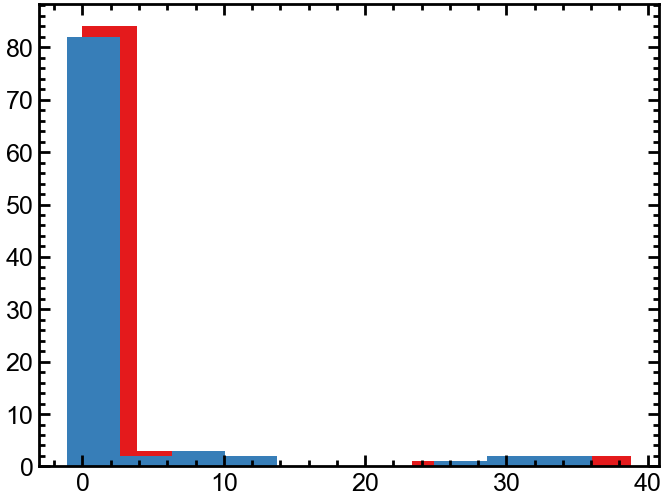

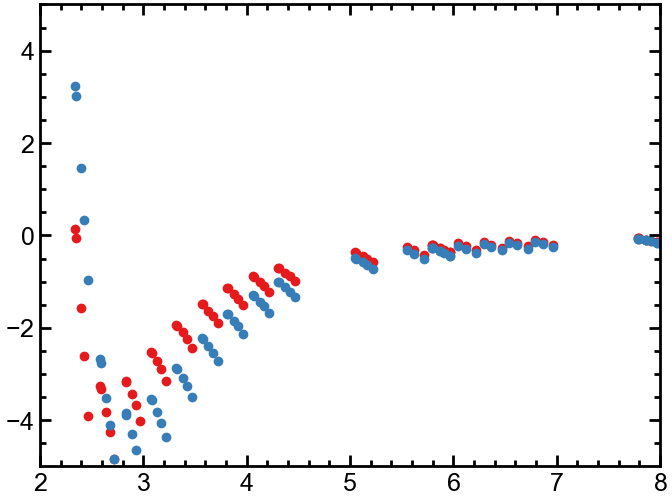

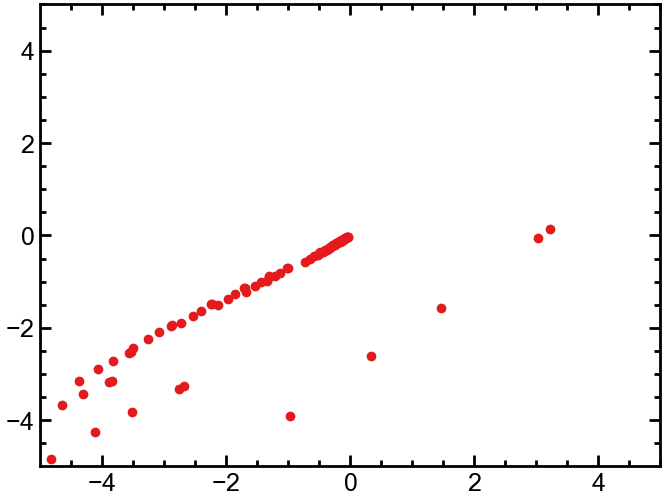

In [32]:
ffeval = ljpcff_fit.eval_best_parm()
plt.hist(ffeval)
plt.hist(ljpcff_fit.targets)
plt.show()

ljpcff_fit.data["eval"] = ffeval

plt.scatter(
    ljpcff_fit.data["OO"], 
    ljpcff_fit.data["eval"] + ljpcff_fit.data["ELEC"]
)

plt.scatter(
    ljpcff_fit.data["OO"], 
    ljpcff_fit.data["intE"]
)

plt.xlim(2,8)
plt.ylim(-5,5)

plt.show()

plt.scatter(
    ljpcff_fit.data["intE"],
    ljpcff_fit.data["eval"] + ljpcff_fit.data["ELEC"],
           )

plt.xlim(-5,5)
plt.ylim(-5,5)

LJMDCM = ljpcff_fit.data["eval"] + ljpcff_fit.data["ELEC"]

In [33]:
fit = "de"
elec = "ELEC"
target = "intE"
data = water_pairs_mdcm.data
depcff_fit = ff_train(fit, elec, target, data)

Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 6 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (1, 8), (6, 20)]
Interaction energy:
KEY
10-1.xyz   -2.125892
10-2.xyz   -1.967529
10-3.xyz   -1.848944
10-4.xyz   -1.710780
10-5.xyz   -1.696969
              ...   
9-1.xyz    -2.725145
9-2.xyz    -2.537622
9-3.xyz    -2.397030
9-4.xyz    -2.238090
9-5.xyz    -2.219390
Name: intE, Length: 94, dtype: float64
count    94.000000
mean     -0.219343
std       4.794958
min      -5.094565
25%      -2.233415
50%      -0.463646
75%      -0.142239
max      22.334219
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [3.088298801104941, 2.554371536730238, 0.4166052940521787, 0.20646948622588554, 7.454747682299664, 5.698315131322651]
sig [6.176597602209882, 5.642670337835179, 5.108743073460476]
ep [0.4166052940521787, 0.29328532357064396, 0.20646948

In [34]:
res = pd.DataFrame(depcff_fit.opt_results).sort_values("fun")
parm = res["x"].iloc[0]
res.head()

,fun,nit,nfev,status,success,message,x,final_simplex
119,0.188949,1001,1617,0,True,Optimization terminated successfully.,"[0.8558165396109899, 1.7283451247183657, 0.001...","([[0.8558165396109899, 1.7283451247183657, 0.0..."
69,0.188958,2387,3693,0,True,Optimization terminated successfully.,"[0.8434925962260489, 1.7298523170510487, 0.001...","([[0.8434925962260489, 1.7298523170510487, 0.0..."
160,0.188967,1405,2247,0,True,Optimization terminated successfully.,"[0.8621485524706196, 1.7277323735310504, 0.001...","([[0.8621485524706196, 1.7277323735310504, 0.0..."
73,0.188978,1092,1769,0,True,Optimization terminated successfully.,"[0.8490050023612971, 1.7292165782768771, 0.001...","([[0.8490050023612971, 1.7292165782768771, 0.0..."
124,0.189000,773,1252,0,True,Optimization terminated successfully.,"[0.8804275371124389, 1.7255410295699432, 0.001...","([[0.8804275371124389, 1.7255410295699432, 0.0..."


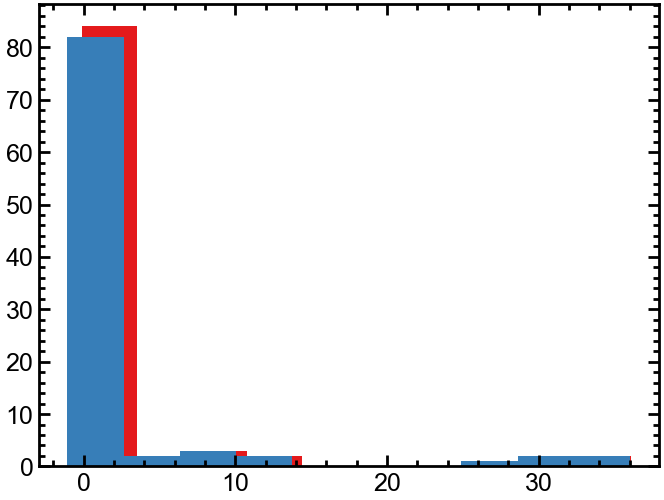

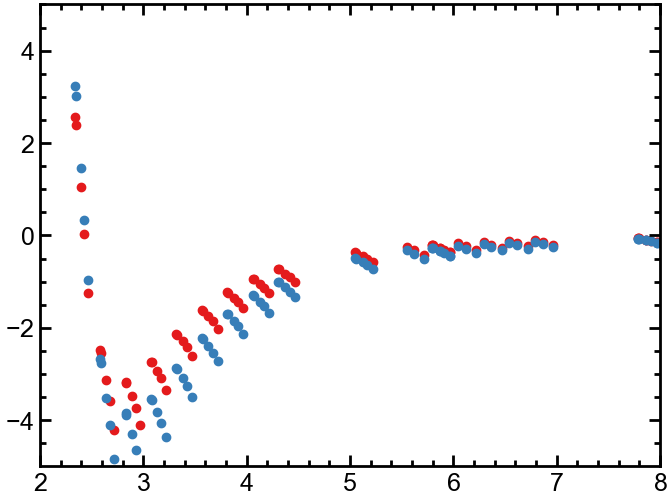

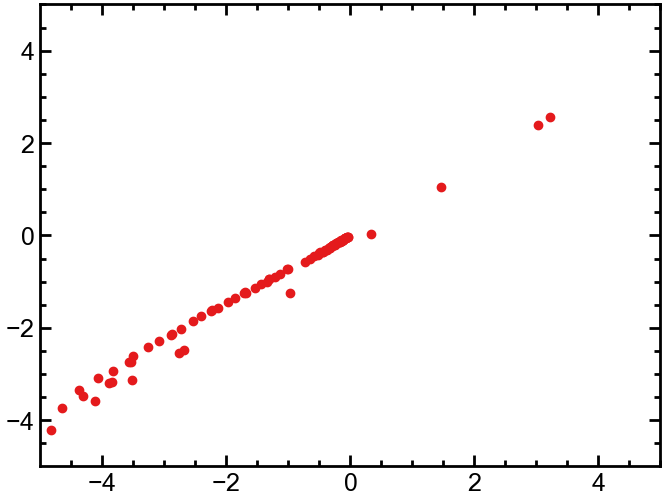

In [35]:
ffeval = depcff_fit.eval_jax_de(parm)
plt.hist(ffeval)
plt.hist(ljpcff_fit.targets)
plt.show()

depcff_fit.data["eval"] = ffeval

plt.scatter(
    depcff_fit.data["OO"], 
    depcff_fit.data["eval"] + depcff_fit.data["ELEC"]
)

plt.scatter(
    depcff_fit.data["OO"], 
    depcff_fit.data["intE"]
)

plt.xlim(2,8)
plt.ylim(-5,5)

plt.show()

plt.scatter(
    depcff_fit.data["intE"],
    depcff_fit.data["eval"] + depcff_fit.data["ELEC"],
           )

plt.xlim(-5,5)
plt.ylim(-5,5)


DEMDCM = depcff_fit.data["eval"] + depcff_fit.data["ELEC"]


In [70]:
def plot_scan(x, y, ax, c="k", nox=False, N=20):
    # print(type(x), [_ for _ in x.values])
    # x = [float(_) for _ in x.values]
    # print(x)
    coefs = np.polyfit(x, y, N)
    p = np.poly1d(coefs)
    ax.plot(x, y, "bo", markersize=2, c=c, alpha=0.2)
    
    XRange = np.arange(0,8,0.1)
    
    ax.plot(XRange, p(XRange), "r-", c=c)
    ax.axhline(c="k", linestyle="--")
    # ax.set_ylim(-2.5,2.5)
    # ax.set_xlim(3.1,8)

    
    return ax


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-10-05 12:25:51 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-10-05 12:25:51 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-10-05 12:25:51 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-10-05 12:25:51 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-10-05 12:25:51 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved


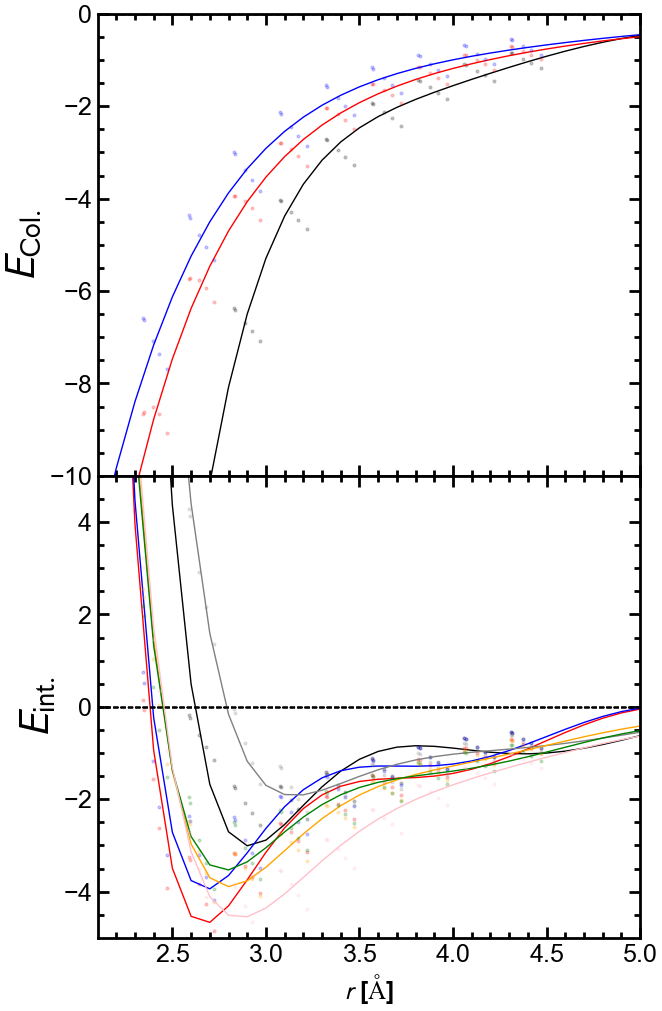

In [71]:
fig, ax = plt.subplots(2,1, figsize=(7,12), sharex=True)
plot_scan(water_pairs_pc.data["OO"], 
    water_pairs_pc.data["CI"], ax[0], N=8, c="k")
plot_scan(water_pairs_mdcm.data["OO"], 
    water_pairs_mdcm.data["ELEC"], ax[0], N=8, c="red")
plot_scan(water_pairs_pc.data["OO"], 
    water_pairs_pc.data["ELEC"], ax[0], N=8, c="blue")


NINT = 10
plot_scan(water_pairs_pc.data["OO"], 
    [LJCI.loc[i] for i in order if i in LJCI.index], ax[1], N=NINT, c="k")
plot_scan(water_pairs_mdcm.data["OO"], 
    [LJMDCM.loc[i] for i in order if i in LJCI.index], ax[1], N=NINT, c="red")
plot_scan(water_pairs_pc.data["OO"], 
    [LJPC.loc[i] for i in order if i in LJCI.index], ax[1], N=NINT, c="blue")

plot_scan(water_pairs_pc.data["OO"], 
    [DECI.loc[i] for i in order if i in LJCI.index], ax[1], N=NINT, c="gray")
plot_scan(water_pairs_mdcm.data["OO"], 
    [DEMDCM.loc[i] for i in order if i in LJCI.index], ax[1], N=NINT, c="orange")
plot_scan(water_pairs_pc.data["OO"], 
    [DEPC.loc[i] for i in order if i in LJCI.index], ax[1], N=NINT, c="green")

plot_scan(water_pairs_pc.data["OO"], 
    water_pairs_pc.data["intE"], ax[1], N=NINT, c="pink")

ax[0].set_ylim(-10,0)
ax[0].set_xlim(2.1,5)

ax[1].set_ylim(-5,5)
ax[1].set_xlim(2.1,5)

ax[1].set_ylabel("$E_{\mathrm{int.}}$", fontsize=30)
ax[1].set_ylabel("$E_{\mathrm{int.}}$", fontsize=30)
ax[0].set_ylabel("$E_{\mathrm{Col.}}$", fontsize=30)
ax[1].set_xlabel("$r$ [$\mathrm{\AA}$]")

plt.subplots_adjust(wspace=0, hspace=0)

In [38]:
# plt.scatter(
#     water_pairs_pc.data["OO"], 
#     water_pairs_pc.data["ELEC"]
# )
# plt.scatter(
#     water_pairs_mdcm.data["OO"], 
#     water_pairs_mdcm.data["ELEC"]
# )
# plt.scatter(
#     water_pairs_mdcm.data["OO"], 
#     water_pairs_mdcm.data["CI"]
# )

In [39]:
plt.show()

In [50]:
DEMDCM.loc[order[0]]

-2.923290776184499

In [43]:
order

['7-3.xyz',
 '3-1.xyz',
 '8-2.xyz',
 '3-3.xyz',
 '9-3.xyz',
 '23-2.xyz',
 '12-1.xyz',
 '20-3.xyz',
 '14-1.xyz',
 '6-3.xyz',
 '3-2.xyz',
 '5-1.xyz',
 '19-3.xyz',
 '12-3.xyz',
 '16-1.xyz',
 '13-1.xyz',
 '10-5.xyz',
 '18-3.xyz',
 '12-2.xyz',
 '6-5.xyz',
 '15-4.xyz',
 '24-2.xyz',
 '18-1.xyz',
 '6-1.xyz',
 '24-3.xyz',
 '22-2.xyz',
 '14-2.xyz',
 '4-3.xyz',
 '23-1.xyz',
 '13-3.xyz',
 '11-1.xyz',
 '24-1.xyz',
 '11-3.xyz',
 '14-4.xyz',
 '23-3.xyz',
 '1-5.xyz',
 '9-2.xyz',
 '4-5.xyz',
 '2-5.xyz',
 '10-4.xyz',
 '15-5.xyz',
 '3-4.xyz',
 '4-2.xyz',
 '15-3.xyz',
 '9-5.xyz',
 '2-1.xyz',
 '11-2.xyz',
 '2-4.xyz',
 '6-4.xyz',
 '7-4.xyz',
 '15-1.xyz',
 '3-5.xyz',
 '10-1.xyz',
 '7-5.xyz',
 '5-2.xyz',
 '1-4.xyz',
 '16-5.xyz',
 '9-1.xyz',
 '5-3.xyz',
 '7-1.xyz',
 '12-5.xyz',
 '11-4.xyz',
 '4-1.xyz',
 '1-3.xyz',
 '13-2.xyz',
 '12-4.xyz',
 '21-1.xyz',
 '2-3.xyz',
 '13-5.xyz',
 '16-2.xyz',
 '22-1.xyz',
 '4-4.xyz',
 '9-4.xyz',
 '10-2.xyz',
 '15-2.xyz',
 '17-2.xyz',
 '17-3.xyz',
 '22-3.xyz',
 '8-4.xyz',
 '11-5.x